# Exercise 2 - QOSF Mentorship program

<hr>

**Task:**
* Prepare 4 random 4-qubit quantum states of your choice.
- Create and train a variational circuit that transforms input states into predefined output states. Namely
  - if random state 1 is provided, it returns state |0011>
  - if random state 2 is provided, it returns state |0101>
  - if random state 3 is provided, it returns state |1010>
  - if random state 4 is provided, it returns state |1100>
- What would happen if you provided a different state?

Analyze and discuss the results.

<hr>

## Solution

In [1]:
# Import modules
%matplotlib notebook

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.functional import normalize
import time

In [2]:
# Circuit high level characteristics
nr_qubits = 4
nr_layers = 2
nr_params = 6

In [3]:
# Input states definition (computational basis)

input_states = {}

for i in range(4):
    input_states[i] = torch.randint(2, (nr_qubits,))

#input_states[0] = [1, 0, 0, 0]
#input_states[1] = [0, 1, 0, 0]
#input_states[2] = [0, 0, 1, 0]
#input_states[3] = [0, 0, 0, 1]

In [4]:
# Target output states definition (on the bloch sphere)
zero = [0., 0.,  1.]
one  = [0., 0., -1.]

target_states = {}

target_states[0] = torch.tensor([zero, zero, one, one])
target_states[1] = torch.tensor([zero, one, zero, one])
target_states[2] = torch.tensor([one, zero, one, zero])
target_states[3] = torch.tensor([one, one, zero, zero])

nr_states = len(target_states)

# Normalization of each target state
for target_state in target_states.values():
    for i in range(len(target_state)):
        target_state[i] = normalize(target_state[i], p=2, dim=0)

In [5]:
# Wrap input and target states in a single structure
states = {}
for i in range(len(target_states)):
    states[i] = {'input': input_states[i],
                 'target': target_states[i]}

In [6]:
# Array of Pauli matrices
Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
Paulis[0] = torch.tensor([[0, 1], [1, 0]])
Paulis[1] = torch.tensor([[0, -1j], [1j, 0]])
Paulis[2] = torch.tensor([[1, 0], [0, -1]])

In [7]:
# Initialize circuit parameters to random values
# following line used to always generate the same parameters to get comparable results during the analysis
random_state = np.random.RandomState(42)

params = random_state.uniform(0, np.pi, (nr_qubits, nr_layers, nr_params))
params = Variable(torch.tensor(params), requires_grad=True)

In [8]:
# Definition of different layers to be applied in the circuit
def rotation_layer(params, j):
    for i in range(nr_qubits):
        qml.RX(params[i, j, 0], wires=i)
        qml.RY(params[i, j, 1], wires=i)

def crot_layer(params, j):    
    for i in range(nr_qubits):
        for k in range(i+1, nr_qubits):
            qml.CRX(params[i, j, 2], wires=[i, k])
            qml.CRX(params[i, j, 3], wires=[k, i])
            qml.CRY(params[i, j, 4], wires=[k, i])
            qml.CRY(params[i, j, 5], wires=[i, k])
                
def cnot_layer():
    for i in range(nr_qubits - 1):
        qml.CNOT(wires=[i, i+1])

In [9]:
# Select device
dev = qml.device("default.qubit", wires=nr_qubits)

In [10]:
# Circuit definition
@qml.qnode(dev, interface="torch")
def circuit(params, A, wire, input_state):

    # Set up initial state
    qml.templates.BasisStatePreparation(input_state, wires=range(nr_qubits))
    
    # Circuit layers
    for j in range(nr_layers):
        rotation_layer(params, j)
        cnot_layer()
        crot_layer(params, j)
    
    return qml.expval(qml.Hermitian(A, wires=wire))

In [11]:
# Cost function for single computed/target states couple
def cost_fn_single_state(params, state):
    
    cost = 0
    for wire in range(nr_qubits):
        for k in range(3):
            cost += torch.abs(circuit(params, Paulis[k], wire, state['input']) - state['target'][wire][k])
            
    return cost

In [12]:
# Cost function
# Cost is the log sum of the difference between each pair of computed and target states 
def cost_fn(params):
    
    cost = 0
    epsilon_ = torch.tensor(1e-7)
        
    for state in states.values():
        cost += torch.log(torch.max(epsilon_, cost_fn_single_state(params, state)))

        
    return cost / (nr_states*nr_qubits)

The following cells contain the code for the optimization. They are meant to executed multiple times, manually lowering the learning rate: this example has been trained starting from $lr = 0.1$ and finishing at $lr = 0.001$.

In [13]:
total_steps = 0

# Initialize variables
best_cost = cost_fn(params)
best_params = params

costs = {'all_costs': {},
         'best_costs': {}}

# Set up the optimizer
lr_ = 0.1
opt = torch.optim.Adam([params], lr=lr_)

The following cells contain the code for the optimization. They are meant to executed multiple times, manually lowering the learning rate: this example has been trained starting from $lr = 0.1, 0.01,$ and $0.001$, each for 500 epochs.

In [38]:
# Optimization

# Set up learning rate
lr_ = 0.001
opt.param_groups[0]['lr'] = lr_


# Number of steps in the optimization routine
steps = 200

print("Best cost after {} steps is {:.4f}  lr={}".format(total_steps, best_cost, lr_))


# Optimization begins
start = time.time()

for n in range(steps):
    opt.zero_grad()

    loss = cost_fn(params)
    costs['all_costs'][n + total_steps] = float(loss)

    loss.backward()
    opt.step()

    # Keep track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

        costs['best_costs'][n + total_steps] = float(best_cost)

    # Vary learning rate
    if n % 100 == 0 and n != 0:
        #lr_ = lr_/10    # Constant learning rate if this line is commented
        opt.param_groups[0]['lr'] = lr_
        
    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Best cost after {} steps is {:.4f}  lr={}   time={:.0f}s".format(total_steps + n + 1, best_cost, lr_, time.time()-start))
        start = time.time()


# Add last best_cost
total_steps += steps
costs['best_costs'][total_steps] = float(best_cost)

Best cost after 1300 steps is 0.0256  lr=0.001
Best cost after 1310 steps is 0.0256  lr=0.001   time=392s
Best cost after 1320 steps is 0.0249  lr=0.001   time=390s
Best cost after 1330 steps is 0.0244  lr=0.001   time=390s
Best cost after 1340 steps is 0.0226  lr=0.001   time=390s
Best cost after 1350 steps is 0.0226  lr=0.001   time=390s
Best cost after 1360 steps is 0.0226  lr=0.001   time=392s
Best cost after 1370 steps is 0.0226  lr=0.001   time=391s
Best cost after 1380 steps is 0.0226  lr=0.001   time=391s
Best cost after 1390 steps is 0.0226  lr=0.001   time=393s
Best cost after 1400 steps is 0.0226  lr=0.001   time=390s
Best cost after 1410 steps is 0.0226  lr=0.001   time=396s
Best cost after 1420 steps is 0.0226  lr=0.001   time=391s
Best cost after 1430 steps is 0.0226  lr=0.001   time=391s
Best cost after 1440 steps is 0.0224  lr=0.001   time=391s
Best cost after 1450 steps is 0.0223  lr=0.001   time=391s
Best cost after 1460 steps is 0.0220  lr=0.001   time=391s
Best cost

<IPython.core.display.Javascript object>


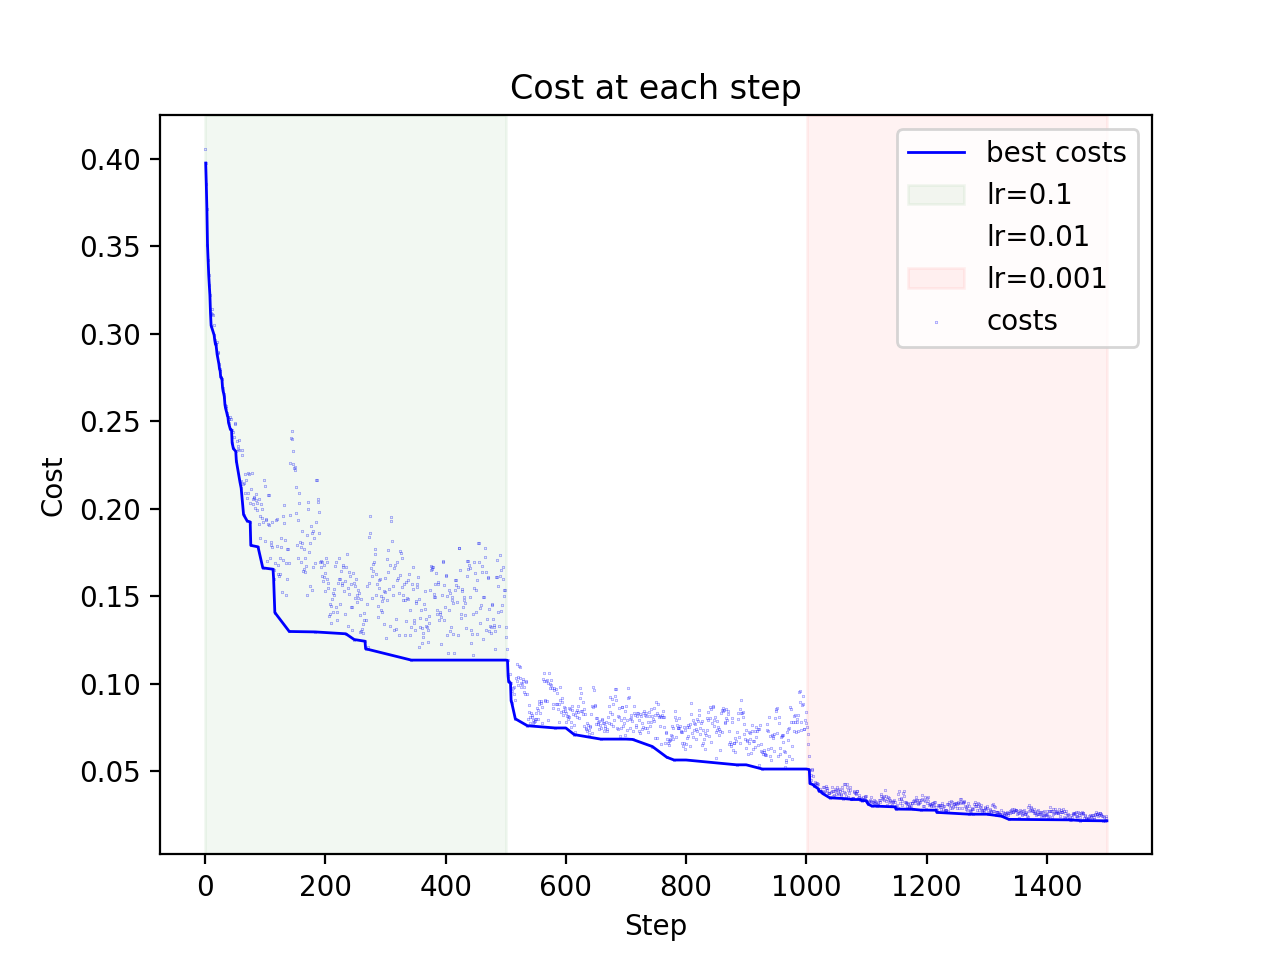

In [81]:
# Plot costs and best_costs

fig, ax = plt.subplots()
ax.scatter(*zip(*sorted(costs['all_costs'].items())), s=0.01, c='b', label='costs')
ax.plot(*zip(*sorted(costs['best_costs'].items())), linewidth=1, c='b', label='best costs')

ax.set(xlabel='Step', ylabel='Cost',
       title='Cost at each step')

# Made in Italy
ax.axvspan(   0,  500, label='lr=0.1'  , alpha=0.05, color='g', linewidth=None)
ax.axvspan( 501, 1000, label='lr=0.01' , alpha=0.05, color='w', linewidth=None)
ax.axvspan(1001, 1500, label='lr=0.001', alpha=0.05, color='r', linewidth=None)

plt.legend(loc="upper right")
plt.show()

Here it follows a comparison between the output states from the trained circuit and the target states. Results are not always correct, possibly due to the circuit structure and the small number of parameters. Using less qubits i found almost no error in the final states, however with 4 qubits there are usually 2 errors in the output.

In [61]:
# Compare target and computed states

output_state = [torch.zeros((nr_qubits, 3)) for _ in range(nr_states)]
for key, state in states.items():
    for wire in range(nr_qubits):
        for k in range(3):
            output_state[key][wire][k] = circuit(best_params, Paulis[k], wire, state['input'])

    for i in range(len(output_state[key])):
        output_state[key][i] = normalize(output_state[key][i], p=2, dim=0)

    # print results
    print('Results for input/target states number {}'.format(key+1))
    print("Target Bloch vector: \n", target_states[key])
    print("Output Bloch vector: \n", output_state[key])
    print("Summed difference between output and target states: \n {:.2e}".format(float(cost_fn_single_state(best_params, states[key]))))
    print('\n')

Results for input/target states number 1
Target Bloch vector: 
 tensor([[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0., -1.],
        [ 0.,  0., -1.]])
Output Bloch vector: 
 tensor([[-0.2137, -0.4753,  0.8535],
        [-0.4841,  0.7906, -0.3749],
        [ 0.5394,  0.1961, -0.8189],
        [ 0.0197,  0.3115, -0.9500]], grad_fn=<CopySlices>)
Summed difference between output and target states: 
 4.19e+00


Results for input/target states number 2
Target Bloch vector: 
 tensor([[ 0.,  0.,  1.],
        [ 0.,  0., -1.],
        [ 0.,  0.,  1.],
        [ 0.,  0., -1.]])
Output Bloch vector: 
 tensor([[-1.0039e-02,  3.4736e-05,  9.9995e-01],
        [-9.7118e-01,  1.3553e-02,  2.3798e-01],
        [ 6.4120e-04,  8.6807e-04,  1.0000e+00],
        [-2.2010e-01,  2.9248e-01, -9.3060e-01]], grad_fn=<CopySlices>)
Summed difference between output and target states: 
 3.03e+00


Results for input/target states number 3
Target Bloch vector: 
 tensor([[ 0.,  0., -1.],
        [ 0.,  

<hr>

**What would happen if you provided a different state?**

The target states given by the task are linearly independent and constitutes a basis for a subspace of dimention 4 in the computational basis, which has dimention $2^{nr\_qubits} = 16$. The same holds for the random input states, except that it's not guaranteed that they all are linearly independent, and we can extract a basis of at most 4 vectors.

The unitary map implemented by the circuit is then defined between theese two basis, but random elsewhere. If a new random state is provided, its components on the input basis are mapped to respective states in the target basis, with the same linear combination, while other components are mapped to fixed but random states.